## Data Unzip

In [1]:
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from glob import glob

import pretty_midi
pretty_midi.pretty_midi.MAX_TICK = 1e10

torch.set_printoptions(sci_mode=False)

In [2]:
maps_path = Path('/home/dasol/userdata/onsets-and-frames/datasets/maps')

# UNZIP
# maps_piano_path = list(maps_path.rglob('*_2.zip'))
# for path in maps_piano_path:
#     zipfile.ZipFile(path).extractall(maps_path)

In [3]:
def time2frame(time, sr=16000, hop_length=512):
    return round((time * sr) / hop_length)

In [4]:
class MAPSDataset:
    def __init__(self, path, split):
        train_path = path / 'train'
        test_path = path / 'test'
        self.path = train_path if split == 'train' else test_path
        self.sample_rate = 16000

        self.files = list(self.path.glob('*.pt'))
        self.data = [torch.load(x) for x in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = self.data[idx]
        audio = data['audio']
        roll = data['label']

        start = random.randint(0, len(audio[0]) - (self.sample_rate * 25) - 1)
        end = start + (self.sample_rate * 20)
        sliced_audio = audio[:, start:end].mean(dim=0) # stereo to mono

        start_roll = time2frame(start/self.sample_rate)
        end_roll = start_roll + int(20 * self.sample_rate/512)
        sliced_roll = roll[:, :, start_roll:end_roll]

        return sliced_audio, sliced_roll     
        

## 데이터 파이프라인

1) DataSet class __getitem__


2) DataLoader 

    2-1) Collate function (collate_fn)

    getitem으로 불러온 N개의 아이템을 어떻게 하나의 텐서로 만들어줄 것인지

    각각의 아이템의 shape 모두 같다면 N x ~~~~
  
  
3) for batch in trainloader:

      batch = batch.to(device) (이때 batch가 tensor들의 튜플이면 각각 device로 보내줘야함)

      audio, roll = batch 

      audio = audio.to(device)

      roll = roll.to(device)
     
      model(audio)


In [5]:
trainset = MAPSDataset(maps_path, 'train')
testset = MAPSDataset(maps_path, 'test')

In [6]:
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=10, num_workers=2)
batch = next(iter(train_loader))

In [7]:
batch[0]

tensor([[-0.0118, -0.0169, -0.0213,  ...,  0.0038,  0.0043,  0.0051],
        [-0.0221, -0.0172, -0.0106,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0448, -0.0634, -0.0711,  ..., -0.0074, -0.0065, -0.0054],
        ...,
        [-0.0141, -0.0085, -0.0028,  ..., -0.0200, -0.0162, -0.0145],
        [-0.0009, -0.0011, -0.0016,  ..., -0.0014, -0.0011,  0.0006],
        [-0.0179, -0.0204, -0.0215,  ..., -0.0158, -0.0149, -0.0139]])

In [8]:
batch[0].shape, batch[1].shape

(torch.Size([8, 320000]), torch.Size([8, 2, 88, 625]))

#### Label끼리 잘 맞나 확인

In [9]:
def check_label(split: str, idx, slice: int):
    if split == 'train':
        _, label = trainset[idx]
    elif split == 'test':
        _, label = testset[idx]
    plt.figure(figsize=(15, 7))
    plt.imshow((label[0] + label[1])[:, :slice], aspect='auto', interpolation='nearest', origin='lower')

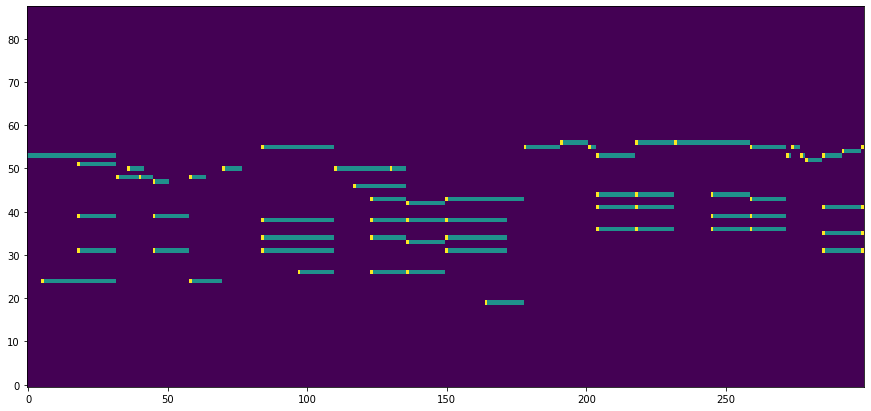

In [10]:
check_label('train', 17, 300)

#### audio-label끼리 잘 맞나 확인

In [11]:
test_audio, test_roll = trainset[112]

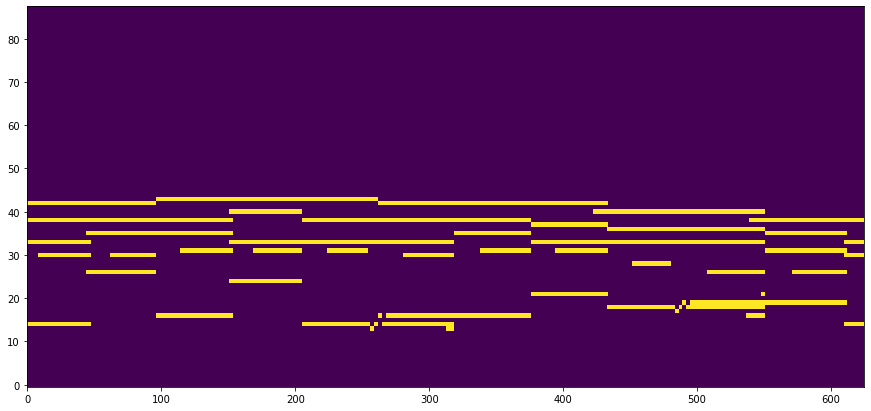

In [12]:
plt.figure(figsize=(15, 7))
plt.imshow(test_roll[0], aspect='auto', interpolation='nearest', origin='lower')

In [13]:
test_audio = test_audio.view([1, -1])
test_audio.shape

torch.Size([1, 320000])

In [14]:
torchaudio.save(filepath='/home/dasol/userdata/onsets-and-frames/audio_samples/sample10.wav', src= test_audio, sample_rate=16000)

## Model

In [9]:
def pitch2hz(pitch):
    return 2 ** ((pitch-69) / 12) * 440

In [10]:
SAMPLE_RATE = 16000
HOP_LENGTH = SAMPLE_RATE * 32 // 1000
MIN_MIDI = 21
MAX_MIDI = 108

N_MELS = 229
MEL_FMIN = 30
MEL_FMAX = SAMPLE_RATE // 2
WINDOW_LENGTH = 2048

DEV = "cuda"

In [11]:
class ConvStack(nn.Module):
    def __init__(self, hidden_size=256):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv2d(1, hidden_size//4, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//4),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//4, hidden_size//2, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size//2),
                                 nn.MaxPool2d((2, 1)),
                                 nn.ReLU(),
                                 
                                 nn.Conv2d(hidden_size//2, hidden_size, kernel_size=(3, 3), padding=1),
                                 nn.BatchNorm2d(hidden_size),
                                 nn.ReLU(),)
                                 
        self.fc = nn.Sequential(
            nn.Linear(88 * hidden_size, hidden_size),
            nn.Dropout(0.5)
        )

    def forward(self, mel_spec):
        out = self.cnn(mel_spec)
        out = out.reshape(mel_spec.shape[0], -1, mel_spec.shape[-1])
        out = self.fc(out.permute(0, 2, 1))
        return out

In [12]:
class BiLSTM(nn.Module):
    def __init__(self, input_features=256, hidden_size=128):
        super().__init__()
        self.rnn = nn.LSTM(input_features, hidden_size, num_layers=3, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.rnn(x)
        return out

In [13]:
class OnsetandFrameModel(nn.Module):
    def __init__(self): 
        super().__init__()
        
        self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                                  n_fft = 2048,
                                                                  hop_length = 512,
                                                                  f_min = 20,
                                                                  f_max = 8000,
                                                                  n_mels = 88 * 4)

        # sequence_model = lambda input_size, output_size: BiLSTM(input_size, output_size // 2)

        self.onset_stack = nn.Sequential(
            ConvStack(),
            BiLSTM(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        ).cuda()
        self.frame_stack = nn.Sequential(
            ConvStack(),
            nn.Linear(256, 88),
            nn.Sigmoid()
        ).cuda()
        self.combined_stack = nn.Sequential(
            BiLSTM(176, 128),
            nn.Linear(256, 88),
            nn.Sigmoid()
        ).cuda()

    def forward(self, x):
        mel_spec = self.mel_converter(x).unsqueeze(1).to(device=DEV)
        onset_pred = self.onset_stack(mel_spec)
        # offset_pred = self.offset_stack(mel_spec)
        activation_pred = self.frame_stack(mel_spec)
        combined_pred = torch.cat([onset_pred.detach(), activation_pred], dim=-1)
        frame_pred = self.combined_stack(combined_pred)
        # velocity_pred = self.velocity_stack(mel_spec)
        return onset_pred.permute(0, 2, 1), activation_pred.permute(0, 2, 1), frame_pred.permute(0, 2, 1)

### binary cross entropy loss

In [14]:
model = OnsetandFrameModel().to(device=DEV)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 100
loss_record = []
test_record = []
BCEloss = nn.BCELoss()
model.train()


for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):

        audio, roll = batch
        onset_pred, activation_pred, frame_pred = model(audio.to(DEV))
        onset_loss = BCEloss(onset_pred[..., :-1].to(torch.float32), roll[:, 1].to(DEV).to(torch.float32))
        frame_loss = BCEloss(frame_pred[..., :-1].to(torch.float32), roll[:, 0].to(DEV).to(torch.float32))
        loss = onset_loss + frame_loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for batch in test_loader:
            audio, roll = batch
            onset_test_pred, activation_test_pred, frame_test_pred = model(audio.to(DEV))
            onset_test_loss = BCEloss(onset_test_pred[..., :-1].to(torch.float32), roll[:, 1].to(DEV).to(torch.float32))
            frame_test_loss = BCEloss(frame_test_pred[..., :-1].to(torch.float32), roll[:, 0].to(DEV).to(torch.float32))
            test_loss = onset_test_loss + frame_test_loss
            epoch_loss += test_loss.item()
            # TODO : Calculate accuracy (F1 score)
        test_record.append(epoch_loss / len(test_loader))
    model.train()

100%|██████████| 100/100 [15:25<00:00,  9.25s/it]


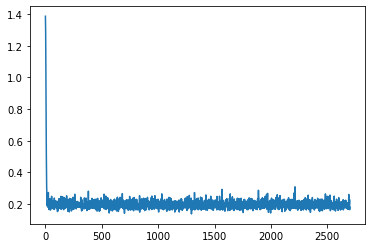

In [18]:
plt.plot(loss_record)

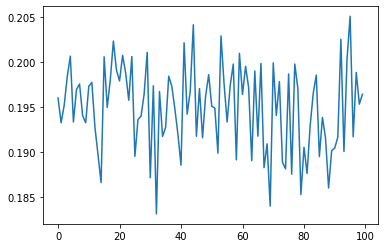

In [19]:
plt.plot(test_record)

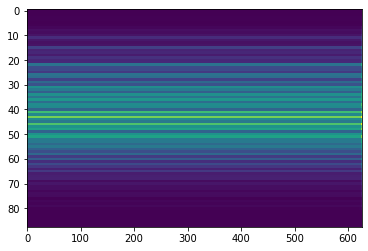

In [20]:
plt.imshow(frame_test_pred[0].cpu(), aspect='auto', interpolation='nearest')

### with f1 score

In [82]:
def f1_score(threshold, roll):
    true_positive = ((threshold==1) * (roll==1)).sum()
    false_positive = ((threshold==1) * (roll==0)).sum()
    false_negative = ((threshold==0) * (roll==1)).sum()

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    f1_score = 2 / ((1 / precision) + (1 / recall))

    return f1_score

In [86]:
model = OnsetandFrameModel().to(device=DEV)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 100
loss_record = []
test_record = []
f1_record = []
BCEloss = nn.BCELoss()
model.train()


for epoch in  tqdm(range(num_epochs)):
    for batch in tqdm(train_loader, leave=False):
        audio, roll = batch
        onset_pred, activation_pred, frame_pred = model(audio.to(device=DEV))
        onset_loss = BCEloss(onset_pred[..., :-1].to(torch.float32), roll[:, 1].to(DEV).to(torch.float32))
        frame_loss = BCEloss(frame_pred[..., :-1].to(torch.float32), roll[:, 0].to(DEV).to(torch.float32))
        loss = onset_loss + frame_loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        loss_record.append(loss.item())

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for batch in test_loader:
            audio, roll = batch
            roll = roll.to(torch.float32)
            onset_test_pred, activation_test_pred, frame_test_pred = model(audio.to(device=DEV))
            onset_test_loss = BCEloss(onset_test_pred[..., :-1].to(torch.float32), roll[:, 1].to(device=DEV))
            frame_test_loss = BCEloss(frame_test_pred[..., :-1].to(torch.float32), roll[:, 0].to(device=DEV))
            test_loss = onset_test_loss + frame_test_loss
            epoch_loss += test_loss.item()

            # TODO : Calculate accuracy (F1 score)
            roll = roll.to(torch.int)
            onset_threshold = (onset_test_pred>=0.01).to(torch.int)[..., :-1]
            frame_threshold = (frame_test_pred>=0.1).to(torch.int)[..., :-1]

            onset_f1_score = f1_score(onset_threshold, roll[:, 1])
            frame_f1_score = f1_score(frame_threshold, roll[:, 0])
            f1_record.append((onset_f1_score + frame_f1_score) / 2)
            
        test_record.append(epoch_loss / len(test_loader))

    model.train()

100%|██████████| 100/100 [15:26<00:00,  9.27s/it]


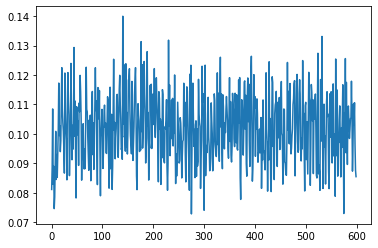

In [87]:
plt.plot(f1_record)

In [88]:
f1_record

[tensor(0.0812),
 tensor(0.0888),
 tensor(0.1085),
 tensor(0.0829),
 tensor(0.0890),
 tensor(0.0747),
 tensor(0.0786),
 tensor(0.0909),
 tensor(0.1009),
 tensor(0.0845),
 tensor(0.0930),
 tensor(0.0852),
 tensor(0.0927),
 tensor(0.1015),
 tensor(0.1173),
 tensor(0.0995),
 tensor(0.1028),
 tensor(0.0940),
 tensor(0.0977),
 tensor(0.1117),
 tensor(0.1225),
 tensor(0.1085),
 tensor(0.1038),
 tensor(0.1009),
 tensor(0.0946),
 tensor(0.0867),
 tensor(0.1207),
 tensor(0.1080),
 tensor(0.1014),
 tensor(0.0979),
 tensor(0.0844),
 tensor(0.1114),
 tensor(0.1208),
 tensor(0.1112),
 tensor(0.1065),
 tensor(0.0859),
 tensor(0.0954),
 tensor(0.1028),
 tensor(0.1239),
 tensor(0.1061),
 tensor(0.0912),
 tensor(0.1029),
 tensor(0.0948),
 tensor(0.1045),
 tensor(0.1293),
 tensor(0.0992),
 tensor(0.1112),
 tensor(0.0941),
 tensor(0.0783),
 tensor(0.1093),
 tensor(0.1088),
 tensor(0.0998),
 tensor(0.1045),
 tensor(0.0893),
 tensor(0.1105),
 tensor(0.1076),
 tensor(0.1199),
 tensor(0.1143),
 tensor(0.1052